In [18]:
%matplotlib inline

### Install Python Packages

In [19]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

In [20]:
torch.cuda.is_available()

True

### GPU Setup

In [21]:
if torch.cuda.is_available():
    print(torch.cuda.current_device())     # The ID of the current GPU.
    print(torch.cuda.get_device_name(id))  # The name of the specified GPU, where id is an integer.
    print(torch.cuda.device(id))           # The memory address of the specified GPU, where id is an integer.
    print(torch.cuda.device_count())

on_gpu = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
NVIDIA GeForce RTX 3060 Ti
1
cuda


### Get MNIST Dataset and DataLoader

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# # Flatten operation (assuming you want to flatten the tensor along the spatial dimensions)
# flatten = transforms.Lambda(lambda x: x.view(-1))

# # Combine the original transforms with the flatten operation
# combined_transform = transforms.Compose([
#     transform,
#     flatten,
# ])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

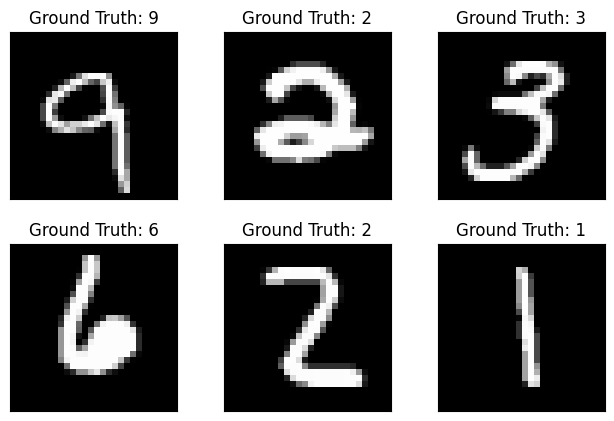

In [23]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Create MLP

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred
    
# =========================================================
# nn.Flatten(),
# nn.Linear(28*28, 28*28),
# nn.ReLU(),
# nn.Linear(28*28, 512),
# nn.ReLU(),
# nn.Linear(512, 256),
# nn.ReLU(),
# nn.Linear(256, 128),
# nn.ReLU(),
# nn.Linear(128, 10),
    
# nn.Flatten(),
# nn.Linear(28*28, 28*28),
# nn.ReLU(),
# nn.Linear(28*28, 28*28),
# nn.ReLU(),
# nn.Linear(28*28, 512),
# nn.ReLU(),
# nn.Linear(512, 256),
# nn.ReLU(),
# nn.Linear(256, 128),
# nn.ReLU(),
# nn.Linear(128, 10),

### Select Model and Define HyperParameters

In [25]:
model = MLP()
# model = CNN()

print(model)

epochs = 50
learning_rate = 0.01
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2000, out_features=2000, bias=True)
    (4): ReLU()
    (5): Linear(in_features=2000, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


### Move Model and Data to GPU

In [26]:
if torch.cuda.is_available():
    print("Moving to Device")
    model.to(device)

Moving to Device


### Define Training Function

In [27]:
train_loss_epoch = np.zeros(epochs)
val_loss_epoch = np.zeros(epochs)

train_acc_epoch = np.zeros(epochs)
val_acc_epoch = np.zeros(epochs)

train_correct_epoch = np.zeros(epochs)
val_correct_epoch = np.zeros(epochs)

def train(epoch, dataloader, optimizer):
    model.train()

    batch_count = len(dataloader)

    loss_accumulator = 0
    correct_accumulator = 0

    print(f'Train Epoch: {epoch+1}')

    for batch, (data, label) in tqdm(enumerate(dataloader), total=batch_count):
        if on_gpu:
            data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()

        loss_accumulator += loss.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct_accumulator += pred.eq(label.data.view_as(pred)).sum()


    train_loss_epoch[epoch] = loss_accumulator / batch_count
    train_acc_epoch[epoch] = correct_accumulator / len(dataloader.dataset)
    train_correct_epoch[epoch] = correct_accumulator

    print(f'Train Set: Average Batch Loss: {loss_accumulator/batch_count:.6f}, Accuracy: {correct_accumulator}/{len(dataloader.dataset)} ({100 * correct_accumulator / len(dataloader.dataset):.0f}%)')

### Define Validation Function

In [28]:
def validation(epoch, dataloader):
    model.eval()
    loss_accumulator = 0
    correct_accumulator = 0
    with torch.no_grad():
        for data, label in dataloader:
            if on_gpu:
                data, label = data.to(device), label.to(device)
            output = model(data)

            loss_accumulator += criterion(output, label)
            # loss += F.nll_loss(output, label, size_average=False).item()

            pred = output.data.max(1, keepdim=True)[1]
            correct_accumulator += pred.eq(label.data.view_as(pred)).sum()

    val_loss_epoch[epoch] = loss_accumulator / len(dataloader)
    val_acc_epoch[epoch] = correct_accumulator / len(dataloader.dataset)
    val_correct_epoch[epoch] = correct_accumulator

    print(f'\nVal Set: Loss: {loss_accumulator/len(dataloader.dataset):.6f}, Accuracy: {correct_accumulator}/{len(dataloader.dataset)} ({100 * correct_accumulator / len(dataloader.dataset):.0f}%)')

### Define Testing Function

In [29]:
def test(dataloader):
    model.eval()
    loss_accumulator = 0
    correct_accumulator = 0
    with torch.no_grad():
        for data, label in dataloader:
            if on_gpu:
                data, label = data.to(device), label.to(device)
            output = model(data)

            loss_accumulator += criterion(output, label)
            # loss += F.nll_loss(output, label, size_average=False).item()

            pred = output.data.max(1, keepdim=True)[1]
            correct_accumulator += pred.eq(label.data.view_as(pred)).sum()

    test_loss = loss_accumulator/len(dataloader.dataset)
    test_accuracy = correct_accumulator/len(dataloader.dataset)
    test_correct = correct_accumulator

    print(f'\nTest Set: Loss: {test_loss:.6f}, Accuracy: {test_correct}/{len(dataloader.dataset)} ({100 * test_accuracy:.0f}%)')

### Train Model

In [30]:
for epoch in range(0, epochs):
     print('==='*30)
     train(epoch=epoch, dataloader=train_loader, optimizer=optimizer)
     validation(epoch=epoch, dataloader=test_loader)

Train Epoch: 1


100%|██████████| 1200/1200 [00:06<00:00, 180.87it/s]


Train Set: Average Batch Loss: 0.759766, Accuracy: 47524/60000 (79%)

Val Set: Loss: 0.006504, Accuracy: 9047/10000 (90%)
Train Epoch: 2


100%|██████████| 1200/1200 [00:06<00:00, 187.36it/s]


Train Set: Average Batch Loss: 0.292897, Accuracy: 54815/60000 (91%)

Val Set: Loss: 0.005111, Accuracy: 9254/10000 (93%)
Train Epoch: 3


100%|██████████| 1200/1200 [00:06<00:00, 183.20it/s]


Train Set: Average Batch Loss: 0.229424, Accuracy: 55903/60000 (93%)

Val Set: Loss: 0.004162, Accuracy: 9370/10000 (94%)
Train Epoch: 4


100%|██████████| 1200/1200 [00:06<00:00, 181.79it/s]


Train Set: Average Batch Loss: 0.184438, Accuracy: 56751/60000 (95%)

Val Set: Loss: 0.003393, Accuracy: 9498/10000 (95%)
Train Epoch: 5


100%|██████████| 1200/1200 [00:06<00:00, 179.67it/s]


Train Set: Average Batch Loss: 0.151799, Accuracy: 57323/60000 (96%)

Val Set: Loss: 0.003108, Accuracy: 9559/10000 (96%)
Train Epoch: 6


100%|██████████| 1200/1200 [00:06<00:00, 181.85it/s]


Train Set: Average Batch Loss: 0.128534, Accuracy: 57724/60000 (96%)

Val Set: Loss: 0.002493, Accuracy: 9624/10000 (96%)
Train Epoch: 7


100%|██████████| 1200/1200 [00:06<00:00, 180.31it/s]


Train Set: Average Batch Loss: 0.110236, Accuracy: 58056/60000 (97%)

Val Set: Loss: 0.002210, Accuracy: 9659/10000 (97%)
Train Epoch: 8


100%|██████████| 1200/1200 [00:06<00:00, 181.09it/s]


Train Set: Average Batch Loss: 0.095634, Accuracy: 58298/60000 (97%)

Val Set: Loss: 0.001976, Accuracy: 9697/10000 (97%)
Train Epoch: 9


100%|██████████| 1200/1200 [00:06<00:00, 183.98it/s]


Train Set: Average Batch Loss: 0.083517, Accuracy: 58526/60000 (98%)

Val Set: Loss: 0.001876, Accuracy: 9710/10000 (97%)
Train Epoch: 10


100%|██████████| 1200/1200 [00:06<00:00, 186.69it/s]


Train Set: Average Batch Loss: 0.073550, Accuracy: 58709/60000 (98%)

Val Set: Loss: 0.001800, Accuracy: 9716/10000 (97%)
Train Epoch: 11


100%|██████████| 1200/1200 [00:06<00:00, 187.16it/s]


Train Set: Average Batch Loss: 0.064451, Accuracy: 58884/60000 (98%)

Val Set: Loss: 0.001671, Accuracy: 9739/10000 (97%)
Train Epoch: 12


100%|██████████| 1200/1200 [00:06<00:00, 188.08it/s]


Train Set: Average Batch Loss: 0.057051, Accuracy: 58985/60000 (98%)

Val Set: Loss: 0.001748, Accuracy: 9724/10000 (97%)
Train Epoch: 13


100%|██████████| 1200/1200 [00:06<00:00, 186.14it/s]


Train Set: Average Batch Loss: 0.051245, Accuracy: 59112/60000 (99%)

Val Set: Loss: 0.001553, Accuracy: 9755/10000 (98%)
Train Epoch: 14


100%|██████████| 1200/1200 [00:06<00:00, 187.97it/s]


Train Set: Average Batch Loss: 0.045016, Accuracy: 59219/60000 (99%)

Val Set: Loss: 0.001576, Accuracy: 9751/10000 (98%)
Train Epoch: 15


100%|██████████| 1200/1200 [00:06<00:00, 189.30it/s]


Train Set: Average Batch Loss: 0.040117, Accuracy: 59319/60000 (99%)

Val Set: Loss: 0.001528, Accuracy: 9744/10000 (97%)
Train Epoch: 16


100%|██████████| 1200/1200 [00:06<00:00, 187.80it/s]


Train Set: Average Batch Loss: 0.035877, Accuracy: 59376/60000 (99%)

Val Set: Loss: 0.001413, Accuracy: 9778/10000 (98%)
Train Epoch: 17


100%|██████████| 1200/1200 [00:06<00:00, 189.70it/s]


Train Set: Average Batch Loss: 0.032215, Accuracy: 59461/60000 (99%)

Val Set: Loss: 0.001414, Accuracy: 9777/10000 (98%)
Train Epoch: 18


100%|██████████| 1200/1200 [00:06<00:00, 183.59it/s]


Train Set: Average Batch Loss: 0.028466, Accuracy: 59531/60000 (99%)

Val Set: Loss: 0.001514, Accuracy: 9759/10000 (98%)
Train Epoch: 19


100%|██████████| 1200/1200 [00:06<00:00, 172.98it/s]


Train Set: Average Batch Loss: 0.025621, Accuracy: 59572/60000 (99%)

Val Set: Loss: 0.001417, Accuracy: 9770/10000 (98%)
Train Epoch: 20


100%|██████████| 1200/1200 [00:06<00:00, 174.29it/s]


Train Set: Average Batch Loss: 0.022601, Accuracy: 59645/60000 (99%)

Val Set: Loss: 0.001498, Accuracy: 9769/10000 (98%)
Train Epoch: 21


100%|██████████| 1200/1200 [00:06<00:00, 176.29it/s]


Train Set: Average Batch Loss: 0.019373, Accuracy: 59717/60000 (100%)

Val Set: Loss: 0.001487, Accuracy: 9774/10000 (98%)
Train Epoch: 22


100%|██████████| 1200/1200 [00:06<00:00, 187.75it/s]


Train Set: Average Batch Loss: 0.017582, Accuracy: 59763/60000 (100%)

Val Set: Loss: 0.001278, Accuracy: 9803/10000 (98%)
Train Epoch: 23


100%|██████████| 1200/1200 [00:06<00:00, 184.62it/s]


Train Set: Average Batch Loss: 0.015332, Accuracy: 59790/60000 (100%)

Val Set: Loss: 0.001322, Accuracy: 9801/10000 (98%)
Train Epoch: 24


100%|██████████| 1200/1200 [00:06<00:00, 187.49it/s]


Train Set: Average Batch Loss: 0.013605, Accuracy: 59828/60000 (100%)

Val Set: Loss: 0.001378, Accuracy: 9791/10000 (98%)
Train Epoch: 25


100%|██████████| 1200/1200 [00:06<00:00, 185.80it/s]


Train Set: Average Batch Loss: 0.012076, Accuracy: 59853/60000 (100%)

Val Set: Loss: 0.001407, Accuracy: 9790/10000 (98%)
Train Epoch: 26


100%|██████████| 1200/1200 [00:06<00:00, 186.68it/s]


Train Set: Average Batch Loss: 0.010592, Accuracy: 59879/60000 (100%)

Val Set: Loss: 0.001316, Accuracy: 9803/10000 (98%)
Train Epoch: 27


100%|██████████| 1200/1200 [00:06<00:00, 183.08it/s]


Train Set: Average Batch Loss: 0.009292, Accuracy: 59902/60000 (100%)

Val Set: Loss: 0.001386, Accuracy: 9799/10000 (98%)
Train Epoch: 28


100%|██████████| 1200/1200 [00:06<00:00, 184.20it/s]


Train Set: Average Batch Loss: 0.008001, Accuracy: 59922/60000 (100%)

Val Set: Loss: 0.001404, Accuracy: 9804/10000 (98%)
Train Epoch: 29


100%|██████████| 1200/1200 [00:06<00:00, 183.59it/s]


Train Set: Average Batch Loss: 0.006966, Accuracy: 59945/60000 (100%)

Val Set: Loss: 0.001337, Accuracy: 9802/10000 (98%)
Train Epoch: 30


100%|██████████| 1200/1200 [00:06<00:00, 187.62it/s]


Train Set: Average Batch Loss: 0.006137, Accuracy: 59957/60000 (100%)

Val Set: Loss: 0.001382, Accuracy: 9802/10000 (98%)
Train Epoch: 31


100%|██████████| 1200/1200 [00:06<00:00, 182.86it/s]


Train Set: Average Batch Loss: 0.005243, Accuracy: 59971/60000 (100%)

Val Set: Loss: 0.001323, Accuracy: 9810/10000 (98%)
Train Epoch: 32


100%|██████████| 1200/1200 [00:06<00:00, 186.39it/s]


Train Set: Average Batch Loss: 0.004831, Accuracy: 59969/60000 (100%)

Val Set: Loss: 0.001365, Accuracy: 9810/10000 (98%)
Train Epoch: 33


100%|██████████| 1200/1200 [00:06<00:00, 184.90it/s]


Train Set: Average Batch Loss: 0.004070, Accuracy: 59981/60000 (100%)

Val Set: Loss: 0.001330, Accuracy: 9815/10000 (98%)
Train Epoch: 34


100%|██████████| 1200/1200 [00:06<00:00, 186.60it/s]


Train Set: Average Batch Loss: 0.003643, Accuracy: 59983/60000 (100%)

Val Set: Loss: 0.001355, Accuracy: 9816/10000 (98%)
Train Epoch: 35


100%|██████████| 1200/1200 [00:06<00:00, 177.65it/s]


Train Set: Average Batch Loss: 0.003682, Accuracy: 59981/60000 (100%)

Val Set: Loss: 0.001352, Accuracy: 9808/10000 (98%)
Train Epoch: 36


100%|██████████| 1200/1200 [00:06<00:00, 178.78it/s]


Train Set: Average Batch Loss: 0.003068, Accuracy: 59986/60000 (100%)

Val Set: Loss: 0.001360, Accuracy: 9812/10000 (98%)
Train Epoch: 37


100%|██████████| 1200/1200 [00:06<00:00, 173.23it/s]


Train Set: Average Batch Loss: 0.002746, Accuracy: 59990/60000 (100%)

Val Set: Loss: 0.001436, Accuracy: 9809/10000 (98%)
Train Epoch: 38


100%|██████████| 1200/1200 [00:06<00:00, 176.02it/s]


Train Set: Average Batch Loss: 0.002435, Accuracy: 59993/60000 (100%)

Val Set: Loss: 0.001380, Accuracy: 9809/10000 (98%)
Train Epoch: 39


100%|██████████| 1200/1200 [00:06<00:00, 180.57it/s]


Train Set: Average Batch Loss: 0.002224, Accuracy: 59996/60000 (100%)

Val Set: Loss: 0.001443, Accuracy: 9811/10000 (98%)
Train Epoch: 40


100%|██████████| 1200/1200 [00:06<00:00, 182.18it/s]


Train Set: Average Batch Loss: 0.002052, Accuracy: 59995/60000 (100%)

Val Set: Loss: 0.001423, Accuracy: 9811/10000 (98%)
Train Epoch: 41


100%|██████████| 1200/1200 [00:06<00:00, 183.67it/s]


Train Set: Average Batch Loss: 0.001856, Accuracy: 59995/60000 (100%)

Val Set: Loss: 0.001441, Accuracy: 9812/10000 (98%)
Train Epoch: 42


100%|██████████| 1200/1200 [00:06<00:00, 181.93it/s]


Train Set: Average Batch Loss: 0.001734, Accuracy: 59997/60000 (100%)

Val Set: Loss: 0.001418, Accuracy: 9817/10000 (98%)
Train Epoch: 43


100%|██████████| 1200/1200 [00:06<00:00, 176.24it/s]


Train Set: Average Batch Loss: 0.001603, Accuracy: 59998/60000 (100%)

Val Set: Loss: 0.001429, Accuracy: 9812/10000 (98%)
Train Epoch: 44


100%|██████████| 1200/1200 [00:07<00:00, 167.83it/s]


Train Set: Average Batch Loss: 0.001465, Accuracy: 59997/60000 (100%)

Val Set: Loss: 0.001451, Accuracy: 9816/10000 (98%)
Train Epoch: 45


100%|██████████| 1200/1200 [00:07<00:00, 170.53it/s]


Train Set: Average Batch Loss: 0.001408, Accuracy: 59998/60000 (100%)

Val Set: Loss: 0.001442, Accuracy: 9813/10000 (98%)
Train Epoch: 46


100%|██████████| 1200/1200 [00:07<00:00, 169.60it/s]


Train Set: Average Batch Loss: 0.001291, Accuracy: 59999/60000 (100%)

Val Set: Loss: 0.001441, Accuracy: 9814/10000 (98%)
Train Epoch: 47


100%|██████████| 1200/1200 [00:06<00:00, 173.14it/s]


Train Set: Average Batch Loss: 0.001224, Accuracy: 59999/60000 (100%)

Val Set: Loss: 0.001449, Accuracy: 9816/10000 (98%)
Train Epoch: 48


100%|██████████| 1200/1200 [00:07<00:00, 171.25it/s]


Train Set: Average Batch Loss: 0.001154, Accuracy: 60000/60000 (100%)

Val Set: Loss: 0.001469, Accuracy: 9817/10000 (98%)
Train Epoch: 49


100%|██████████| 1200/1200 [00:06<00:00, 173.02it/s]


Train Set: Average Batch Loss: 0.001097, Accuracy: 60000/60000 (100%)

Val Set: Loss: 0.001496, Accuracy: 9815/10000 (98%)
Train Epoch: 50


100%|██████████| 1200/1200 [00:07<00:00, 168.44it/s]


Train Set: Average Batch Loss: 0.001044, Accuracy: 60000/60000 (100%)

Val Set: Loss: 0.001477, Accuracy: 9812/10000 (98%)


### Test Model

In [31]:
test(test_loader)


Test Set: Loss: 0.001477, Accuracy: 9812/10000 (98%)


### Plot Results

Text(0.5, 1.0, 'Loss Per Epoch')

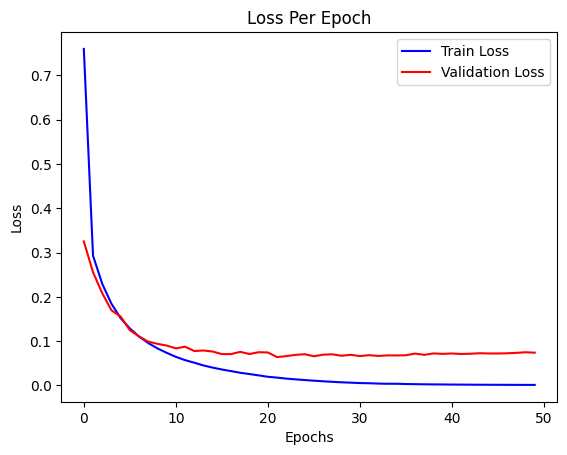

In [32]:
fig = plt.figure()
plt.plot(train_loss_epoch, color='blue')
plt.plot(val_loss_epoch, color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Per Epoch')

Text(0.5, 1.0, 'Accuracy Per Epoch')

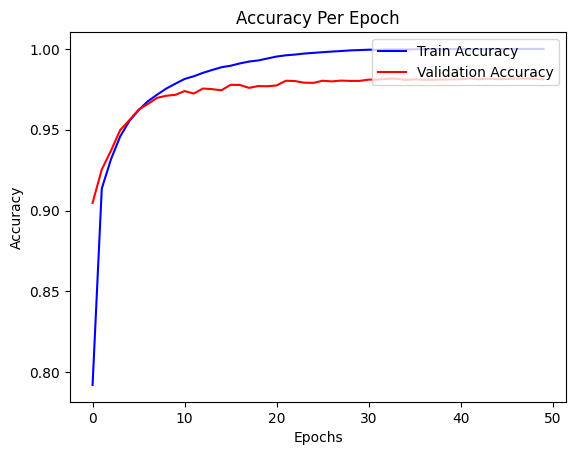

In [33]:
fig = plt.figure()
plt.plot(train_acc_epoch, color='blue')
plt.plot(val_acc_epoch, color='red')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Epoch')

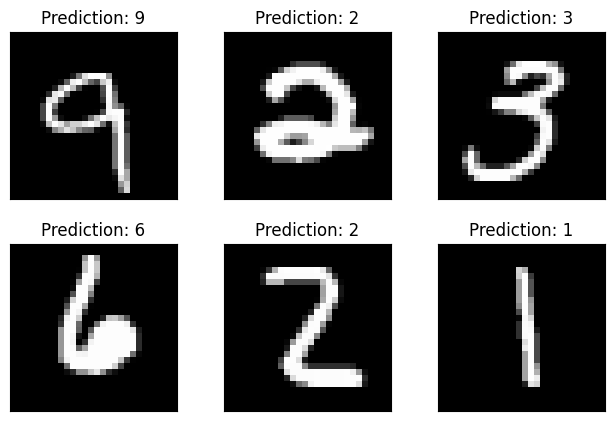

In [34]:
with torch.no_grad():
  if torch.cuda.is_available():
    model = model.to(torch.device('cpu'))
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])